In [14]:
# !pip install tqdm
# !pip install torchsummary

In [1]:
# Importing relevant packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

from project1_model import ResNet, BasicBlock


In [2]:
# fetching device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# parameters
num_workers = 10
batch_size = 128
learningRate = 0.2
weight_decay = 0.0005
res_blocks = [2,3,2]
num_res_layer = len(res_blocks)
kernel=(5,2)
skip_kernel=(3,1)
channels = 32

#### Mean and Standard Deviation for Cifar Dataset -

Mean: tensor([0.4914, 0.4822, 0.4465])

Standard deviation: tensor([0.2471, 0.2435, 0.2616])

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(degrees=(90)),
        transforms.RandomCrop(32, padding=4),
        #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2471, 0.2435, 0.2616]),
#         transforms.RandomErasing(),

    ]),
    'val': transforms.Compose([
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2471, 0.2435, 0.2616])
    ]),
}


dataloaders = {}
for phase in ['train','val']:
    dataset = datasets.CIFAR10(root='./data', train=(phase=='train'),download=True, transform=data_transforms[phase])
    dataloaders[phase] = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=(phase=='train'), num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
model = ResNet(BasicBlock, channels, num_res_layer, res_blocks,kernel=kernel,skip_kernel=skip_kernel)
model = model.to(device)

In [5]:
LossFunc = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weight_decay)

save_loss = {'train':[], 'val':[]}
save_acc = {'train':[], 'val':[]}

In [6]:
from torchsummary import summary
print(summary(model, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]          25,632
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]          25,632
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]          25,632
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]          25,632
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          51,264
      BatchNorm2d-14           [-1, 64,

In [7]:
for epoch in tqdm(range(100)):
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        current_loss = 0.0
        current_corrects = 0

        for batch_idx, (inputs, labels) in enumerate(dataloaders[phase], 1):
            inputs,labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Time to carry out the forward training poss
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = LossFunc(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # We want variables to hold the loss/acc statistics
            current_loss += loss.item() * inputs.size(0)
            current_corrects += torch.sum(preds == labels.data)
        # saving variable for plottin
        save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
        save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]
        # train_loss = train_loss/len(trainloader)
        # test_loss = test_loss/len(testloader)
        # train_loss_history.append(train_loss)
        # test_loss_history.append(test_loss)
        # print('Train loss %s, Test loss %s'%(train_loss, test_loss))
        # pretty print
        print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:0 -- Phase:train -- Loss:1.48 -- Acc:45.81


  1%|          | 1/100 [00:19<31:52, 19.32s/it]

Epoch:0 -- Phase:val -- Loss:1.46 -- Acc:51.25
Epoch:1 -- Phase:train -- Loss:0.99 -- Acc:64.76


  2%|▏         | 2/100 [00:38<31:33, 19.32s/it]

Epoch:1 -- Phase:val -- Loss:1.04 -- Acc:64.16
Epoch:2 -- Phase:train -- Loss:0.79 -- Acc:72.13


  3%|▎         | 3/100 [00:57<31:11, 19.29s/it]

Epoch:2 -- Phase:val -- Loss:0.88 -- Acc:70.24
Epoch:3 -- Phase:train -- Loss:0.67 -- Acc:76.52


  4%|▍         | 4/100 [01:17<30:49, 19.26s/it]

Epoch:3 -- Phase:val -- Loss:0.73 -- Acc:75.40
Epoch:4 -- Phase:train -- Loss:0.59 -- Acc:79.37


  5%|▌         | 5/100 [01:36<30:28, 19.25s/it]

Epoch:4 -- Phase:val -- Loss:1.06 -- Acc:68.06
Epoch:5 -- Phase:train -- Loss:0.54 -- Acc:81.37


  6%|▌         | 6/100 [01:55<30:05, 19.21s/it]

Epoch:5 -- Phase:val -- Loss:1.36 -- Acc:63.37
Epoch:6 -- Phase:train -- Loss:0.49 -- Acc:83.20


  7%|▋         | 7/100 [02:14<29:48, 19.23s/it]

Epoch:6 -- Phase:val -- Loss:0.78 -- Acc:73.58
Epoch:7 -- Phase:train -- Loss:0.45 -- Acc:84.29


  8%|▊         | 8/100 [02:33<29:28, 19.22s/it]

Epoch:7 -- Phase:val -- Loss:0.57 -- Acc:80.99
Epoch:8 -- Phase:train -- Loss:0.42 -- Acc:85.49


  9%|▉         | 9/100 [02:53<29:05, 19.19s/it]

Epoch:8 -- Phase:val -- Loss:0.65 -- Acc:78.63
Epoch:9 -- Phase:train -- Loss:0.39 -- Acc:86.31


 10%|█         | 10/100 [03:12<28:42, 19.14s/it]

Epoch:9 -- Phase:val -- Loss:0.57 -- Acc:80.74
Epoch:10 -- Phase:train -- Loss:0.37 -- Acc:87.13


 11%|█         | 11/100 [03:31<28:27, 19.19s/it]

Epoch:10 -- Phase:val -- Loss:0.51 -- Acc:83.23
Epoch:11 -- Phase:train -- Loss:0.35 -- Acc:87.86


 12%|█▏        | 12/100 [03:50<28:06, 19.17s/it]

Epoch:11 -- Phase:val -- Loss:0.52 -- Acc:82.64
Epoch:12 -- Phase:train -- Loss:0.33 -- Acc:88.64


 13%|█▎        | 13/100 [04:09<27:49, 19.19s/it]

Epoch:12 -- Phase:val -- Loss:0.57 -- Acc:82.17
Epoch:13 -- Phase:train -- Loss:0.31 -- Acc:89.31


 14%|█▍        | 14/100 [04:29<27:32, 19.21s/it]

Epoch:13 -- Phase:val -- Loss:0.57 -- Acc:82.47
Epoch:14 -- Phase:train -- Loss:0.30 -- Acc:89.68


 15%|█▌        | 15/100 [04:48<27:13, 19.22s/it]

Epoch:14 -- Phase:val -- Loss:0.49 -- Acc:83.77
Epoch:15 -- Phase:train -- Loss:0.29 -- Acc:89.97


 16%|█▌        | 16/100 [05:07<26:55, 19.24s/it]

Epoch:15 -- Phase:val -- Loss:0.53 -- Acc:83.27
Epoch:16 -- Phase:train -- Loss:0.28 -- Acc:90.53


 17%|█▋        | 17/100 [05:26<26:36, 19.24s/it]

Epoch:16 -- Phase:val -- Loss:0.56 -- Acc:82.83
Epoch:17 -- Phase:train -- Loss:0.26 -- Acc:90.80


 18%|█▊        | 18/100 [05:45<26:17, 19.24s/it]

Epoch:17 -- Phase:val -- Loss:0.71 -- Acc:80.16
Epoch:18 -- Phase:train -- Loss:0.25 -- Acc:91.43


 19%|█▉        | 19/100 [06:05<25:58, 19.24s/it]

Epoch:18 -- Phase:val -- Loss:0.47 -- Acc:85.07
Epoch:19 -- Phase:train -- Loss:0.24 -- Acc:91.56


 20%|██        | 20/100 [06:24<25:39, 19.24s/it]

Epoch:19 -- Phase:val -- Loss:0.45 -- Acc:85.32
Epoch:20 -- Phase:train -- Loss:0.23 -- Acc:91.91


 21%|██        | 21/100 [06:43<25:20, 19.25s/it]

Epoch:20 -- Phase:val -- Loss:0.65 -- Acc:81.61
Epoch:21 -- Phase:train -- Loss:0.22 -- Acc:92.31


 22%|██▏       | 22/100 [07:02<25:00, 19.24s/it]

Epoch:21 -- Phase:val -- Loss:0.57 -- Acc:81.87
Epoch:22 -- Phase:train -- Loss:0.21 -- Acc:92.59


 23%|██▎       | 23/100 [07:22<24:40, 19.23s/it]

Epoch:22 -- Phase:val -- Loss:0.54 -- Acc:83.99
Epoch:23 -- Phase:train -- Loss:0.21 -- Acc:92.75


 24%|██▍       | 24/100 [07:41<24:21, 19.23s/it]

Epoch:23 -- Phase:val -- Loss:0.45 -- Acc:85.71
Epoch:24 -- Phase:train -- Loss:0.20 -- Acc:92.92


 25%|██▌       | 25/100 [08:00<24:02, 19.23s/it]

Epoch:24 -- Phase:val -- Loss:0.88 -- Acc:75.97
Epoch:25 -- Phase:train -- Loss:0.19 -- Acc:93.35


 26%|██▌       | 26/100 [08:19<23:42, 19.22s/it]

Epoch:25 -- Phase:val -- Loss:0.48 -- Acc:85.67
Epoch:26 -- Phase:train -- Loss:0.19 -- Acc:93.41


 27%|██▋       | 27/100 [08:39<23:23, 19.23s/it]

Epoch:26 -- Phase:val -- Loss:0.56 -- Acc:83.33
Epoch:27 -- Phase:train -- Loss:0.18 -- Acc:93.80


 28%|██▊       | 28/100 [08:58<23:03, 19.22s/it]

Epoch:27 -- Phase:val -- Loss:0.73 -- Acc:80.83
Epoch:28 -- Phase:train -- Loss:0.18 -- Acc:93.73


 29%|██▉       | 29/100 [09:17<22:44, 19.22s/it]

Epoch:28 -- Phase:val -- Loss:0.38 -- Acc:88.33
Epoch:29 -- Phase:train -- Loss:0.17 -- Acc:94.23


 30%|███       | 30/100 [09:36<22:24, 19.21s/it]

Epoch:29 -- Phase:val -- Loss:0.39 -- Acc:87.65
Epoch:30 -- Phase:train -- Loss:0.17 -- Acc:94.28


 31%|███       | 31/100 [09:55<22:07, 19.24s/it]

Epoch:30 -- Phase:val -- Loss:0.55 -- Acc:84.73
Epoch:31 -- Phase:train -- Loss:0.16 -- Acc:94.43


 32%|███▏      | 32/100 [10:15<21:48, 19.24s/it]

Epoch:31 -- Phase:val -- Loss:0.50 -- Acc:85.36
Epoch:32 -- Phase:train -- Loss:0.16 -- Acc:94.57


 33%|███▎      | 33/100 [10:34<21:30, 19.25s/it]

Epoch:32 -- Phase:val -- Loss:0.43 -- Acc:87.47
Epoch:33 -- Phase:train -- Loss:0.15 -- Acc:94.67


 34%|███▍      | 34/100 [10:53<21:10, 19.26s/it]

Epoch:33 -- Phase:val -- Loss:0.40 -- Acc:87.96
Epoch:34 -- Phase:train -- Loss:0.15 -- Acc:94.72


 35%|███▌      | 35/100 [11:12<20:50, 19.24s/it]

Epoch:34 -- Phase:val -- Loss:0.43 -- Acc:87.04
Epoch:35 -- Phase:train -- Loss:0.14 -- Acc:95.15


 36%|███▌      | 36/100 [11:32<20:31, 19.24s/it]

Epoch:35 -- Phase:val -- Loss:0.43 -- Acc:87.55
Epoch:36 -- Phase:train -- Loss:0.15 -- Acc:94.93


 37%|███▋      | 37/100 [11:51<20:12, 19.25s/it]

Epoch:36 -- Phase:val -- Loss:0.59 -- Acc:84.26
Epoch:37 -- Phase:train -- Loss:0.14 -- Acc:95.24


 38%|███▊      | 38/100 [12:10<19:52, 19.24s/it]

Epoch:37 -- Phase:val -- Loss:0.72 -- Acc:81.32
Epoch:38 -- Phase:train -- Loss:0.14 -- Acc:95.15


 39%|███▉      | 39/100 [12:29<19:33, 19.23s/it]

Epoch:38 -- Phase:val -- Loss:0.64 -- Acc:83.14
Epoch:39 -- Phase:train -- Loss:0.13 -- Acc:95.41


 40%|████      | 40/100 [12:49<19:14, 19.24s/it]

Epoch:39 -- Phase:val -- Loss:0.46 -- Acc:86.17
Epoch:40 -- Phase:train -- Loss:0.13 -- Acc:95.40


 41%|████      | 41/100 [13:08<18:53, 19.22s/it]

Epoch:40 -- Phase:val -- Loss:0.42 -- Acc:87.57
Epoch:41 -- Phase:train -- Loss:0.13 -- Acc:95.63


 42%|████▏     | 42/100 [13:27<18:35, 19.23s/it]

Epoch:41 -- Phase:val -- Loss:0.50 -- Acc:86.22
Epoch:42 -- Phase:train -- Loss:0.12 -- Acc:95.70


 43%|████▎     | 43/100 [13:46<18:15, 19.22s/it]

Epoch:42 -- Phase:val -- Loss:0.44 -- Acc:87.18
Epoch:43 -- Phase:train -- Loss:0.12 -- Acc:95.83


 44%|████▍     | 44/100 [14:06<17:57, 19.24s/it]

Epoch:43 -- Phase:val -- Loss:0.45 -- Acc:87.49
Epoch:44 -- Phase:train -- Loss:0.12 -- Acc:95.90


 45%|████▌     | 45/100 [14:25<17:39, 19.25s/it]

Epoch:44 -- Phase:val -- Loss:0.37 -- Acc:89.41
Epoch:45 -- Phase:train -- Loss:0.11 -- Acc:95.99


 46%|████▌     | 46/100 [14:44<17:20, 19.26s/it]

Epoch:45 -- Phase:val -- Loss:0.45 -- Acc:87.38
Epoch:46 -- Phase:train -- Loss:0.12 -- Acc:95.96


 47%|████▋     | 47/100 [15:03<17:00, 19.25s/it]

Epoch:46 -- Phase:val -- Loss:0.47 -- Acc:86.95
Epoch:47 -- Phase:train -- Loss:0.11 -- Acc:96.13


 48%|████▊     | 48/100 [15:23<16:40, 19.23s/it]

Epoch:47 -- Phase:val -- Loss:0.54 -- Acc:85.98
Epoch:48 -- Phase:train -- Loss:0.12 -- Acc:96.00


 49%|████▉     | 49/100 [15:42<16:20, 19.23s/it]

Epoch:48 -- Phase:val -- Loss:0.42 -- Acc:88.06
Epoch:49 -- Phase:train -- Loss:0.11 -- Acc:96.32


 50%|█████     | 50/100 [16:01<16:00, 19.22s/it]

Epoch:49 -- Phase:val -- Loss:0.44 -- Acc:87.93
Epoch:50 -- Phase:train -- Loss:0.11 -- Acc:96.11


 51%|█████     | 51/100 [16:20<15:42, 19.24s/it]

Epoch:50 -- Phase:val -- Loss:0.47 -- Acc:86.87
Epoch:51 -- Phase:train -- Loss:0.11 -- Acc:96.33


 52%|█████▏    | 52/100 [16:40<15:23, 19.24s/it]

Epoch:51 -- Phase:val -- Loss:0.46 -- Acc:87.40
Epoch:52 -- Phase:train -- Loss:0.11 -- Acc:96.28


 53%|█████▎    | 53/100 [16:59<15:04, 19.25s/it]

Epoch:52 -- Phase:val -- Loss:0.45 -- Acc:87.62
Epoch:53 -- Phase:train -- Loss:0.11 -- Acc:96.48


 54%|█████▍    | 54/100 [17:18<14:45, 19.24s/it]

Epoch:53 -- Phase:val -- Loss:0.40 -- Acc:89.00
Epoch:54 -- Phase:train -- Loss:0.10 -- Acc:96.53


 55%|█████▌    | 55/100 [17:37<14:26, 19.25s/it]

Epoch:54 -- Phase:val -- Loss:0.50 -- Acc:86.71
Epoch:55 -- Phase:train -- Loss:0.10 -- Acc:96.54


 56%|█████▌    | 56/100 [17:57<14:06, 19.24s/it]

Epoch:55 -- Phase:val -- Loss:0.54 -- Acc:85.85
Epoch:56 -- Phase:train -- Loss:0.10 -- Acc:96.43


 57%|█████▋    | 57/100 [18:16<13:47, 19.24s/it]

Epoch:56 -- Phase:val -- Loss:0.38 -- Acc:89.33
Epoch:57 -- Phase:train -- Loss:0.10 -- Acc:96.47


 58%|█████▊    | 58/100 [18:35<13:28, 19.26s/it]

Epoch:57 -- Phase:val -- Loss:0.40 -- Acc:88.58
Epoch:58 -- Phase:train -- Loss:0.10 -- Acc:96.67


 59%|█████▉    | 59/100 [18:54<13:09, 19.26s/it]

Epoch:58 -- Phase:val -- Loss:0.44 -- Acc:88.01
Epoch:59 -- Phase:train -- Loss:0.10 -- Acc:96.76


 60%|██████    | 60/100 [19:14<12:50, 19.25s/it]

Epoch:59 -- Phase:val -- Loss:0.46 -- Acc:87.63
Epoch:60 -- Phase:train -- Loss:0.10 -- Acc:96.72


 61%|██████    | 61/100 [19:33<12:30, 19.25s/it]

Epoch:60 -- Phase:val -- Loss:0.45 -- Acc:87.30
Epoch:61 -- Phase:train -- Loss:0.09 -- Acc:96.84


 62%|██████▏   | 62/100 [19:52<12:10, 19.23s/it]

Epoch:61 -- Phase:val -- Loss:0.41 -- Acc:88.66
Epoch:62 -- Phase:train -- Loss:0.10 -- Acc:96.72


 63%|██████▎   | 63/100 [20:11<11:50, 19.21s/it]

Epoch:62 -- Phase:val -- Loss:0.52 -- Acc:85.84
Epoch:63 -- Phase:train -- Loss:0.10 -- Acc:96.69


 64%|██████▍   | 64/100 [20:30<11:31, 19.22s/it]

Epoch:63 -- Phase:val -- Loss:0.44 -- Acc:87.99
Epoch:64 -- Phase:train -- Loss:0.09 -- Acc:96.81


 65%|██████▌   | 65/100 [20:50<11:13, 19.25s/it]

Epoch:64 -- Phase:val -- Loss:0.52 -- Acc:86.77
Epoch:65 -- Phase:train -- Loss:0.10 -- Acc:96.62


 66%|██████▌   | 66/100 [21:09<10:53, 19.23s/it]

Epoch:65 -- Phase:val -- Loss:0.38 -- Acc:89.21
Epoch:66 -- Phase:train -- Loss:0.09 -- Acc:96.98


 67%|██████▋   | 67/100 [21:28<10:34, 19.22s/it]

Epoch:66 -- Phase:val -- Loss:0.70 -- Acc:83.60
Epoch:67 -- Phase:train -- Loss:0.09 -- Acc:96.99


 68%|██████▊   | 68/100 [21:47<10:14, 19.22s/it]

Epoch:67 -- Phase:val -- Loss:0.39 -- Acc:89.36
Epoch:68 -- Phase:train -- Loss:0.09 -- Acc:96.91


 69%|██████▉   | 69/100 [22:06<09:55, 19.21s/it]

Epoch:68 -- Phase:val -- Loss:0.37 -- Acc:90.09
Epoch:69 -- Phase:train -- Loss:0.09 -- Acc:96.94


 70%|███████   | 70/100 [22:26<09:36, 19.21s/it]

Epoch:69 -- Phase:val -- Loss:0.41 -- Acc:88.94
Epoch:70 -- Phase:train -- Loss:0.09 -- Acc:96.79


 71%|███████   | 71/100 [22:45<09:17, 19.22s/it]

Epoch:70 -- Phase:val -- Loss:0.45 -- Acc:87.73
Epoch:71 -- Phase:train -- Loss:0.09 -- Acc:96.98


 72%|███████▏  | 72/100 [23:04<08:58, 19.23s/it]

Epoch:71 -- Phase:val -- Loss:0.46 -- Acc:87.52
Epoch:72 -- Phase:train -- Loss:0.09 -- Acc:97.00


 73%|███████▎  | 73/100 [23:23<08:39, 19.23s/it]

Epoch:72 -- Phase:val -- Loss:0.42 -- Acc:88.96
Epoch:73 -- Phase:train -- Loss:0.09 -- Acc:96.84


 74%|███████▍  | 74/100 [23:43<08:19, 19.20s/it]

Epoch:73 -- Phase:val -- Loss:0.48 -- Acc:87.77
Epoch:74 -- Phase:train -- Loss:0.09 -- Acc:97.12


 75%|███████▌  | 75/100 [24:02<07:59, 19.17s/it]

Epoch:74 -- Phase:val -- Loss:0.53 -- Acc:86.60
Epoch:75 -- Phase:train -- Loss:0.08 -- Acc:97.18


 76%|███████▌  | 76/100 [24:21<07:38, 19.08s/it]

Epoch:75 -- Phase:val -- Loss:0.45 -- Acc:87.99
Epoch:76 -- Phase:train -- Loss:0.08 -- Acc:97.17


 77%|███████▋  | 77/100 [24:40<07:18, 19.06s/it]

Epoch:76 -- Phase:val -- Loss:0.39 -- Acc:89.29
Epoch:77 -- Phase:train -- Loss:0.09 -- Acc:96.97


 78%|███████▊  | 78/100 [24:58<06:58, 19.02s/it]

Epoch:77 -- Phase:val -- Loss:0.49 -- Acc:87.64
Epoch:78 -- Phase:train -- Loss:0.09 -- Acc:97.10


 79%|███████▉  | 79/100 [25:18<06:39, 19.03s/it]

Epoch:78 -- Phase:val -- Loss:0.51 -- Acc:86.92
Epoch:79 -- Phase:train -- Loss:0.08 -- Acc:97.13


 80%|████████  | 80/100 [25:36<06:19, 18.99s/it]

Epoch:79 -- Phase:val -- Loss:0.42 -- Acc:89.17
Epoch:80 -- Phase:train -- Loss:0.09 -- Acc:97.06


 81%|████████  | 81/100 [25:55<06:00, 18.96s/it]

Epoch:80 -- Phase:val -- Loss:0.41 -- Acc:89.08
Epoch:81 -- Phase:train -- Loss:0.08 -- Acc:97.27


 82%|████████▏ | 82/100 [26:14<05:41, 18.95s/it]

Epoch:81 -- Phase:val -- Loss:0.38 -- Acc:89.65
Epoch:82 -- Phase:train -- Loss:0.08 -- Acc:97.24


 83%|████████▎ | 83/100 [26:33<05:21, 18.94s/it]

Epoch:82 -- Phase:val -- Loss:0.40 -- Acc:88.99
Epoch:83 -- Phase:train -- Loss:0.08 -- Acc:97.17


 84%|████████▍ | 84/100 [26:52<05:02, 18.94s/it]

Epoch:83 -- Phase:val -- Loss:0.47 -- Acc:87.60
Epoch:84 -- Phase:train -- Loss:0.08 -- Acc:97.35


 85%|████████▌ | 85/100 [27:11<04:44, 18.94s/it]

Epoch:84 -- Phase:val -- Loss:0.48 -- Acc:87.22
Epoch:85 -- Phase:train -- Loss:0.08 -- Acc:97.18


 86%|████████▌ | 86/100 [27:30<04:25, 18.93s/it]

Epoch:85 -- Phase:val -- Loss:0.47 -- Acc:87.59
Epoch:86 -- Phase:train -- Loss:0.09 -- Acc:97.03


 87%|████████▋ | 87/100 [27:49<04:05, 18.91s/it]

Epoch:86 -- Phase:val -- Loss:0.45 -- Acc:88.35
Epoch:87 -- Phase:train -- Loss:0.08 -- Acc:97.22


 88%|████████▊ | 88/100 [28:08<03:47, 18.93s/it]

Epoch:87 -- Phase:val -- Loss:0.46 -- Acc:87.98
Epoch:88 -- Phase:train -- Loss:0.08 -- Acc:97.30


 89%|████████▉ | 89/100 [28:27<03:28, 18.93s/it]

Epoch:88 -- Phase:val -- Loss:0.45 -- Acc:88.49
Epoch:89 -- Phase:train -- Loss:0.08 -- Acc:97.17


 90%|█████████ | 90/100 [28:46<03:09, 18.96s/it]

Epoch:89 -- Phase:val -- Loss:0.44 -- Acc:88.60
Epoch:90 -- Phase:train -- Loss:0.08 -- Acc:97.24


 91%|█████████ | 91/100 [29:05<02:50, 19.00s/it]

Epoch:90 -- Phase:val -- Loss:0.42 -- Acc:88.69
Epoch:91 -- Phase:train -- Loss:0.08 -- Acc:97.32


 92%|█████████▏| 92/100 [29:24<02:32, 19.01s/it]

Epoch:91 -- Phase:val -- Loss:0.39 -- Acc:89.28
Epoch:92 -- Phase:train -- Loss:0.08 -- Acc:97.42


 93%|█████████▎| 93/100 [29:43<02:12, 18.97s/it]

Epoch:92 -- Phase:val -- Loss:0.46 -- Acc:87.74
Epoch:93 -- Phase:train -- Loss:0.08 -- Acc:97.44


 94%|█████████▍| 94/100 [30:02<01:53, 18.95s/it]

Epoch:93 -- Phase:val -- Loss:0.41 -- Acc:89.97
Epoch:94 -- Phase:train -- Loss:0.08 -- Acc:97.31


 95%|█████████▌| 95/100 [30:21<01:34, 18.97s/it]

Epoch:94 -- Phase:val -- Loss:0.49 -- Acc:87.12
Epoch:95 -- Phase:train -- Loss:0.08 -- Acc:97.21


 96%|█████████▌| 96/100 [30:40<01:15, 18.97s/it]

Epoch:95 -- Phase:val -- Loss:0.40 -- Acc:89.67
Epoch:96 -- Phase:train -- Loss:0.08 -- Acc:97.10


 97%|█████████▋| 97/100 [30:59<00:56, 18.95s/it]

Epoch:96 -- Phase:val -- Loss:0.47 -- Acc:87.73
Epoch:97 -- Phase:train -- Loss:0.08 -- Acc:97.33


 98%|█████████▊| 98/100 [31:17<00:37, 18.95s/it]

Epoch:97 -- Phase:val -- Loss:0.47 -- Acc:87.87
Epoch:98 -- Phase:train -- Loss:0.08 -- Acc:97.38


 99%|█████████▉| 99/100 [31:36<00:18, 18.95s/it]

Epoch:98 -- Phase:val -- Loss:0.57 -- Acc:85.24
Epoch:99 -- Phase:train -- Loss:0.08 -- Acc:97.43


100%|██████████| 100/100 [31:55<00:00, 19.16s/it]

Epoch:99 -- Phase:val -- Loss:0.40 -- Acc:89.60


In [8]:
print(max(save_acc['val']),min(save_loss['val']))

tensor(0.9009, device='cuda:0') 0.36526497249603274


Text(0.5, 1.0, 'Accuracy')

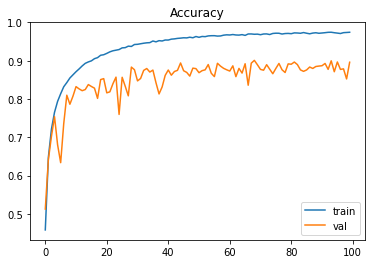

In [10]:
plt.plot(save_acc['train'])
plt.plot(save_acc['val'])
plt.legend(["train", "val"])
plt.title("Accuracy")


Text(0.5, 1.0, 'Loss')

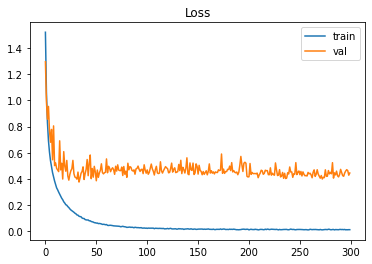

In [18]:
plt.plot(save_loss['train'])
plt.plot(save_loss['val'])
plt.legend(["train", "val"])
plt.title("Loss")

In [24]:
# save resnet model
PATH = './project1_model.pt'
torch.save(model.state_dict(), PATH)

In [26]:
device

device(type='cuda')

In [14]:
print(max(save_acc['val']),min(save_loss['val']))

tensor(0.8506, device='cuda:0') 0.5760338544845581
